# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = r'/data'
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
MODEL_ARC = 'resnet50'
DATASET = 'ImageNet'

METRIC = lambda x,y: 1-metrics.AUROC(x,y)#metrics.AURC

In [6]:
with torch.no_grad():
    logits_v2,labels_v2 = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'v2', device = dev,data_dir = DATA_PATH)
    risk_v2 = measures.wrong_class(logits_v2,labels_v2).float()
    logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)
    risk = measures.wrong_class(logits,labels).float()

In [7]:
print(f'Test (ID) Accuracy: {100*(1-risk.mean().item()):.2f}')

print(f'ImageNetv2 Accuracy: {100*(1-risk_v2.mean().item()):.2f}')

Test (ID) Accuracy: 80.86
ImageNetv2 Accuracy: 69.87


In [8]:
p_star = pNormSoftmax.optimize.p(logits_v2,risk_v2,METRIC)
pT_star = pNormSoftmax.optimize.p_and_beta(logits_v2,risk_v2,METRIC)
T_star = pNormSoftmax.optimize.T(logits_v2,risk_v2,METRIC)

p = pNormSoftmax.optimize.p(logits,risk,METRIC)
beta = pNormSoftmax.beta_heuristic(logits,p)
pT = pNormSoftmax.optimize.p_and_beta(logits,risk,METRIC)
T = pNormSoftmax.optimize.T(logits,risk,METRIC)

In [9]:
baseline = metrics.RC_curve(risk,measures.MSP(logits))
baseline_v2 = metrics.RC_curve(risk_v2,measures.MSP(logits_v2))
T_star_RC = metrics.RC_curve(risk_v2,measures.MSP(logits_v2.div(T_star)))
p_star_RC = metrics.RC_curve(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,p_star,None))
pT_star_RC = metrics.RC_curve(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,pT_star[0],pT_star[1]))
optimal = metrics.RC_curve(risk_v2,1-risk_v2)

In [10]:
T_RC = metrics.RC_curve(risk_v2,measures.MSP(logits_v2.div(T)))
p_RC = metrics.RC_curve(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,p,beta))
pT_RC = metrics.RC_curve(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,pT[0],pT[1]))

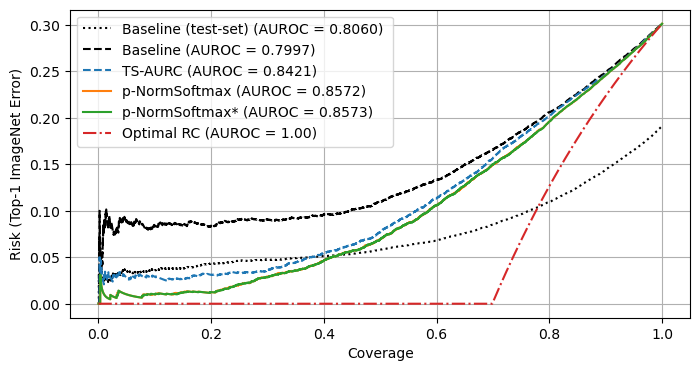

In [11]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
auroc = metrics.AUROC(risk,measures.MSP(logits))
plt.plot(*baseline,'k:', label  = 'Baseline (test-set)'+ f' (AUROC = {auroc:.4f}) ')
auroc = metrics.AUROC(risk_v2,measures.MSP(logits_v2))
plt.plot(*baseline_v2,'k--', label  = 'Baseline'+ f' (AUROC = {auroc:.4f}) ')
auroc = metrics.AUROC(risk_v2,measures.MSP(logits_v2.div(T_star)))
plt.plot(*T_star_RC, '--',label  = 'TS-AURC'+ f' (AUROC = {auroc:.4f})')

auroc = metrics.AUROC(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,p_star,None))
plt.plot(*p_star_RC, label  = 'p-NormSoftmax'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,pT_star[0],pT_star[1]))
plt.plot(*pT_star_RC, label  = 'p-NormSoftmax*'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_v2,risk_v2.logical_not().float())
plt.plot(*optimal,'-.', label  = 'Optimal RC'+ f' (AUROC = {auroc:.2f})')

plt.grid()
plt.legend()
plt.xlabel('Coverage')
plt.ylabel('Risk (Top-1 ImageNet Error)')
plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

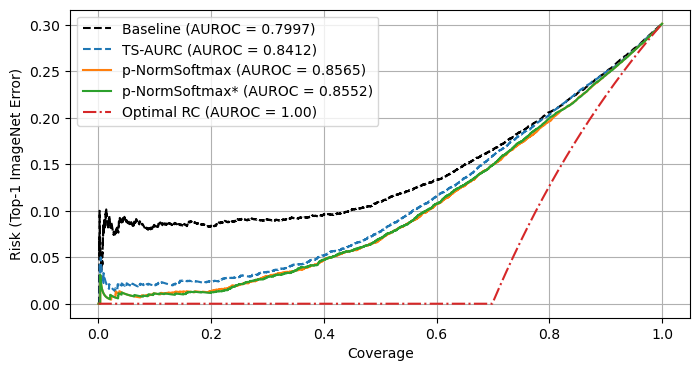

In [12]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
auroc = metrics.AUROC(risk_v2,measures.MSP(logits_v2))
plt.plot(*baseline_v2,'k--', label  = 'Baseline'+ f' (AUROC = {auroc:.4f}) ')
auroc = metrics.AUROC(risk_v2,measures.MSP(logits_v2.div(T)))
plt.plot(*T_RC, '--',label  = 'TS-AURC'+ f' (AUROC = {auroc:.4f})')

auroc = metrics.AUROC(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,p,None))
plt.plot(*p_RC, label  = 'p-NormSoftmax'+ f' (AUROC = {auroc:.4f})')
auroc = metrics.AUROC(risk_v2,pNormSoftmax.pNormSoftmax(logits_v2,pT[0],pT[1]))
plt.plot(*pT_RC, label  = 'p-NormSoftmax*'+ f' (AUROC = {auroc:.4f})')

auroc = metrics.AUROC(risk_v2,risk_v2.logical_not().float())
plt.plot(*optimal,'-.', label  = 'Optimal RC'+ f' (AUROC = {auroc:.2f})')

plt.grid()
plt.legend()
plt.xlabel('Coverage')
plt.ylabel('Risk (Top-1 ImageNet Error)')
plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

In [19]:
c,r,t = baseline = metrics.RC_curve(risk,measures.MSP(logits), return_thresholds= True)
c_v2,r_v2,t_v2 = baseline = metrics.RC_curve(risk_v2,measures.MSP(logits_v2), return_thresholds= True)
t[-1] = 0; t_v2[-1] = 0

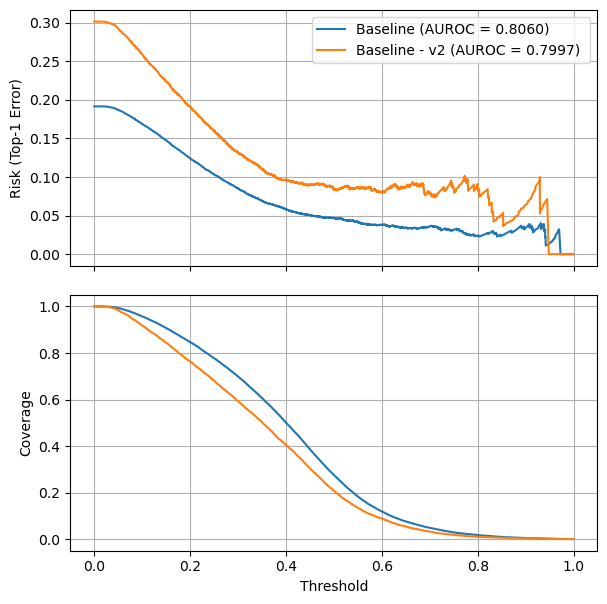

In [21]:
fig,axes = plt.subplots(2,1,figsize = (6,6), sharex = True)
fig.tight_layout()
auroc = metrics.AUROC(risk,measures.MSP(logits))
axes[0].plot(t,r, label  = 'Baseline'+ f' (AUROC = {auroc:.4f}) ')
axes[1].plot(t,c, label  = 'Baseline'+ f' (AUROC = {auroc:.4f}) ')
auroc = metrics.AUROC(risk_v2,measures.MSP(logits_v2))
axes[0].plot(t_v2,r_v2, label  = 'Baseline - v2'+ f' (AUROC = {auroc:.4f}) ')
axes[1].plot(t_v2,c_v2, label  = 'Baseline - v2'+ f' (AUROC = {auroc:.4f}) ')


axes[1].set_xlabel('Threshold')
axes[0].legend()
axes[0].set_ylabel('Risk (Top-1 Error)')
axes[1].set_ylabel('Coverage')
for ax in axes:
    ax.grid()
    
#plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()